## Recursion formulae for $\mathbb{i}_v$

In this notebook we validate our recursion formulae for the integral $\mathbb{i}$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import binom

Here's the definition of the $\mathbb{i}$ integral, computed numerically:

In [9]:
def iexact(v, alpha):
    """
    The function i_v evaluated by direct numerical integration.
    
    """
    res = 0
    for i in range(0, len(alpha), 2):
        func = lambda x: np.sin(x) ** (2 * v)
        res += quad(func, alpha[i], alpha[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return res

And here's our expression, computed recursively from a trivial lower boundary condition:

In [10]:
def Delta(x):
    """The sum over the pairwise differences of an array."""
    return sum(-np.array(x)[::2] + np.array(x)[1::2])


def i(v, alpha):
    """
    The function i_v computed from a lower boundary condition
    and a two-term upward recurrence relation.
    
    """
    if v == 0:
        return Delta(alpha)
    else:
        term = np.sin(alpha) ** (2 * v - 1) * np.cos(alpha)
        return 1.0 / (2 * v) * ((2 * v - 1) * i(v - 1, alpha) - Delta(term))

We can validate the expression over a range of $\{\alpha_1, \alpha_2 \}$ for $v=3$:

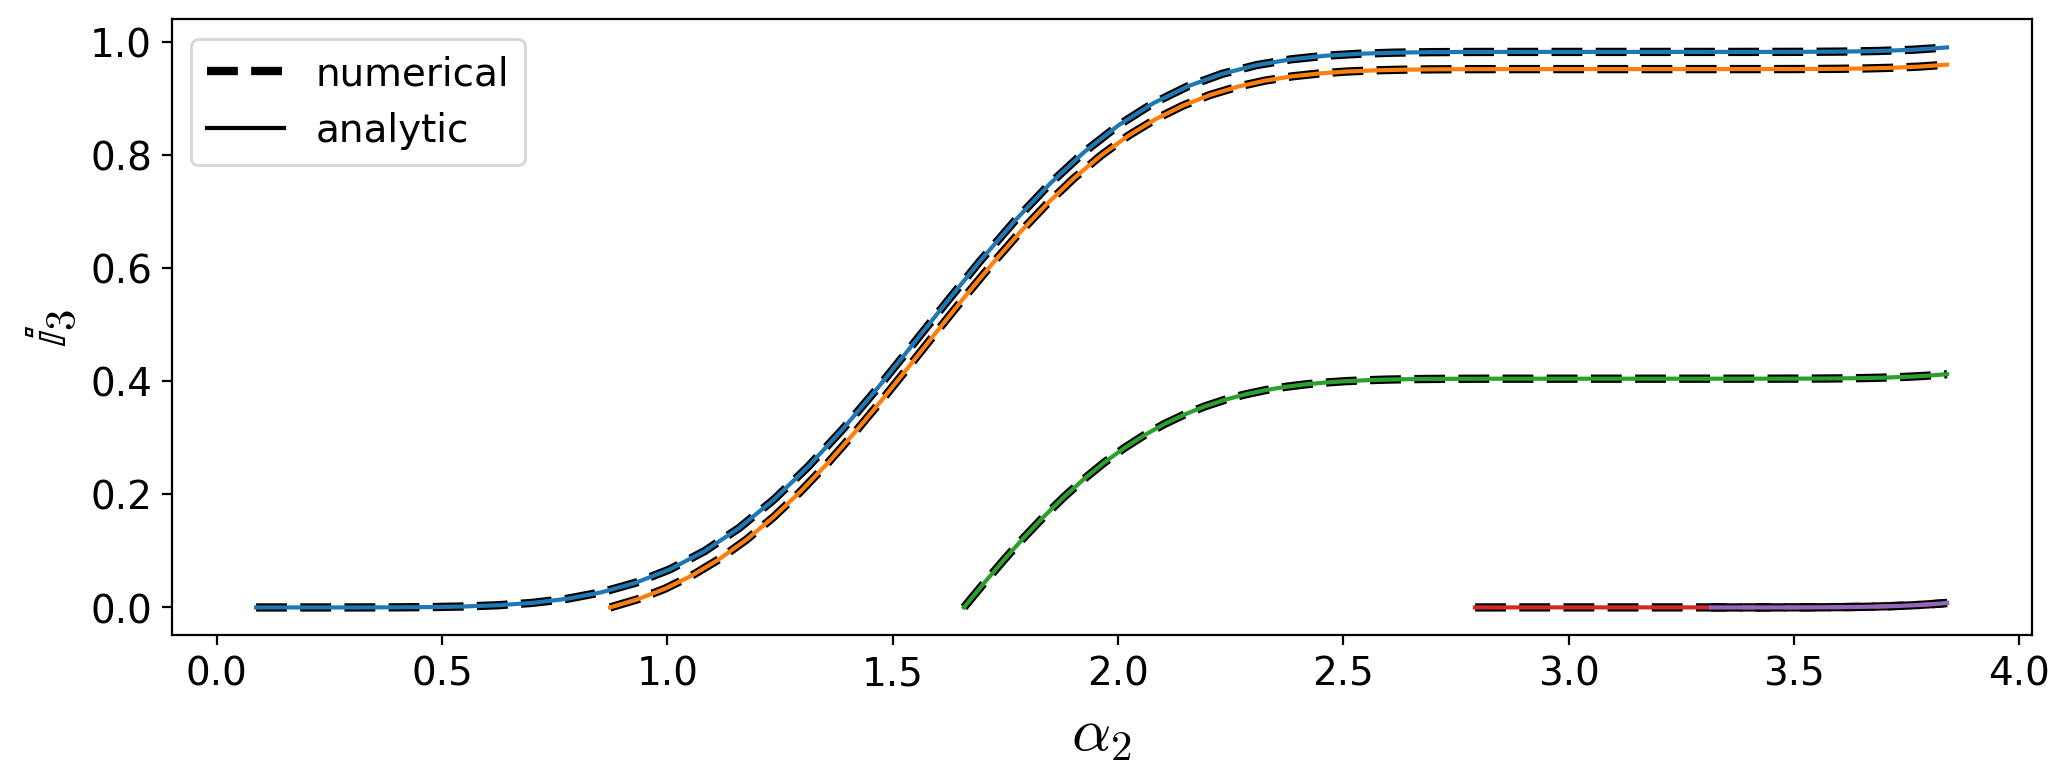

In [19]:
# Validation
for alpha1 in np.array([5, 50, 95, 160, 190]) * np.pi / 180:
    arr = np.linspace(alpha1, 220 * np.pi / 180, 50)
    plt.plot(
        arr, [iexact(3, np.array([alpha1, alpha2])) for alpha2 in arr], "k--", lw=3
    )
    plt.plot(arr, [i(3, np.array([alpha1, alpha2])) for alpha2 in arr])
plt.plot(np.nan, np.nan, "k--", lw=3, label="numerical")
plt.plot(np.nan, np.nan, "k-", label="analytic")
plt.legend()
plt.xlabel(r"$\alpha_2$", fontsize=22)
plt.ylabel(r"$\mathbb{i}_3$", fontsize=22);

where different colors correspond to different values of $\alpha_1$.

## Solver for $\mathbb{i}$

Here's the full recursive solver for all $\mathbb{i}_v$ in one go:

In [20]:
def solve(N, alpha):
    
    # Useful quantities
    s = np.sin(alpha)
    s2 = s ** 2
    term = s * np.cos(alpha)
    
    # Lower boundary
    i = np.empty(N + 1)
    i[0] = Delta(alpha)
    
    # Recurse upward
    for v in range(1, N + 1):
        i[v] = 1.0 / (2 * v) * ((2 * v - 1) * i[v - 1] - Delta(term))
        term *= s2
        
    return i

And here's a simple check that the recursive solver agrees with direct numerical integration for a specific combination of input parameters:

In [22]:
def solve_numerical(N, alpha):
    return np.array([iexact(v, alpha) for v in range(N + 1)])

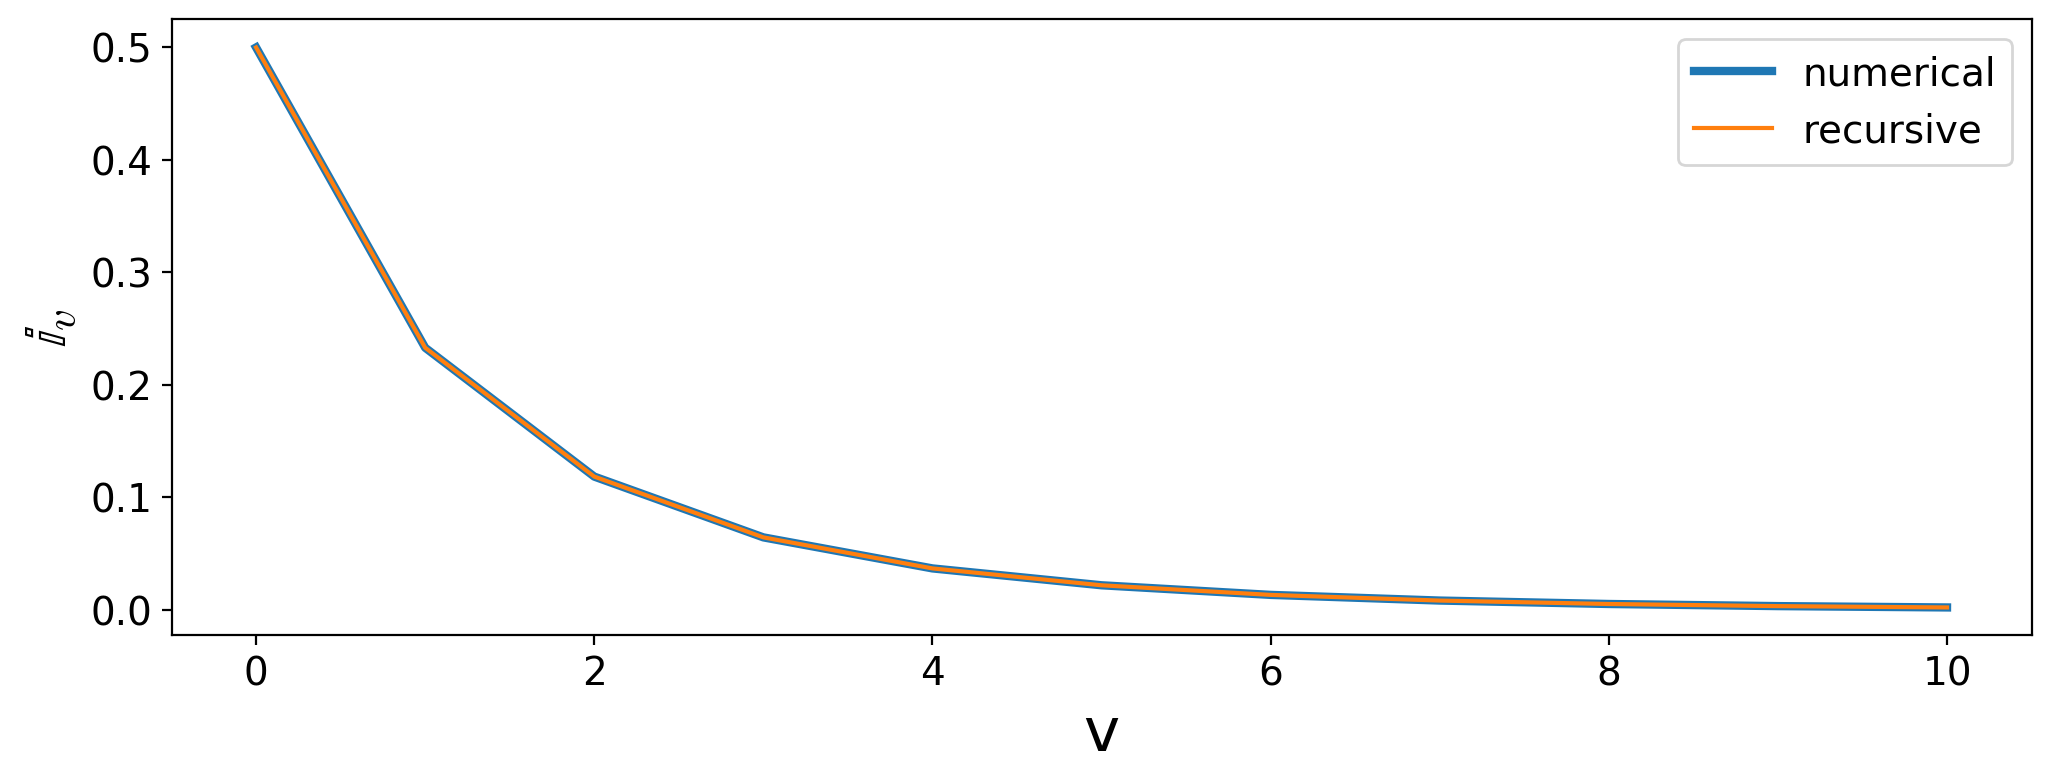

In [23]:
alpha = np.array([0.5, 1.0])
N = 10
plt.plot(solve_numerical(N, alpha), lw=3, label="numerical")
plt.plot(solve(N, alpha), lw=1.5, label="recursive")
plt.xlabel("v", fontsize=22)
plt.ylabel("$\mathbb{i}_v$", fontsize=22)
plt.legend();

## Solver stability

We pick random values of $\{\alpha_1, \alpha_2 \}$ and compute the difference between the numerical and recursive solver to test the numerical stability of the algorithm:

In [25]:
np.random.seed(0)

def random_alpha():
    """Random (alpha1, alpha2) in the range [0, pi] with alpha2 > alpha1."""
    alpha1 = np.pi * np.random.random()
    alpha2 = alpha1 + (np.pi - alpha1) * np.random.random()
    return np.array([alpha1, alpha2])

ntimes = 1000
N = 20
logdiff = np.zeros((ntimes, N + 1))
for i in tqdm(range(ntimes)):
    alpha = random_alpha()
    logdiff[i] = np.log10(np.maximum(1e-16, np.abs(solve(N, alpha) - solve_numerical(N, alpha))))

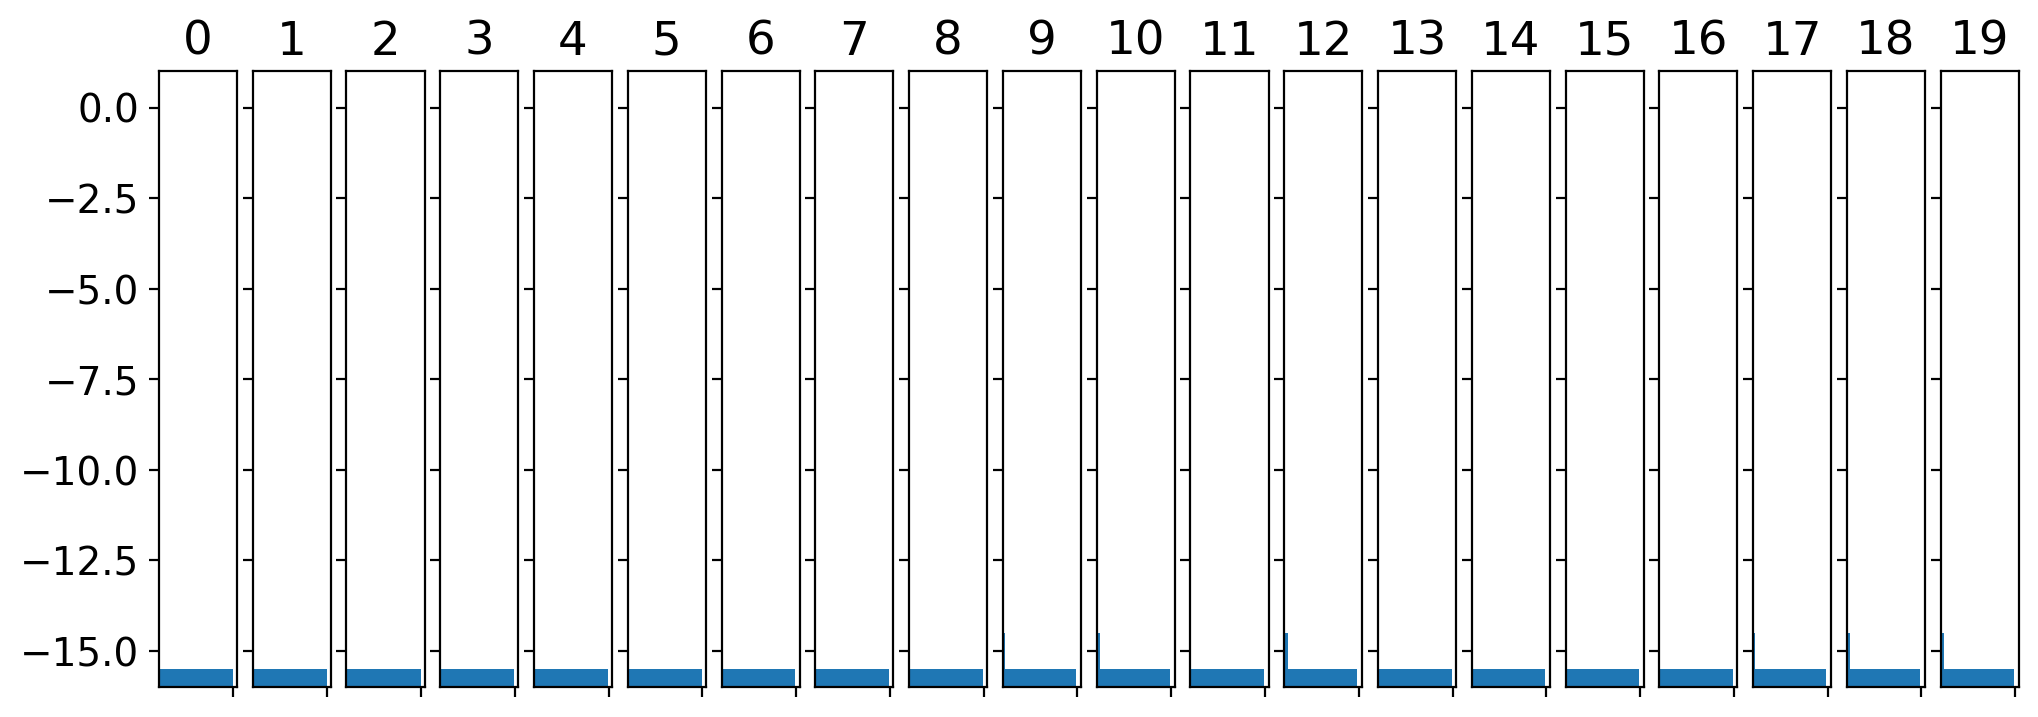

In [26]:
fig, ax = plt.subplots(1, N, sharex=True, sharey=True)
ax[0].set_ylim(-16, 1)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
for i, axis in enumerate(ax):
    axis.set_title(i)
    axis.hist(logdiff[:, i], orientation="horizontal", bins=np.arange(-16.5, 0))

The expressions agree to within better than $10^{-15}$ in all cases.